# Table of contents

1. [Get data](#Get-data)
2. [Check data](#Check-data)
3. [Plot](#Plot)

# Import os library to run get data part

In [1]:
import os

# Get data
<div class="alert alert-block alert-danger"> <b> I created some scripts to get data from the server and parse them correctly. They will be downloaded into your machine, so you don't need to run these chunk again in the future.</b> This is just to make sure that we are analyzing on the same data and tutor can check them easily 

Check current working directory, make sure this directory is where you want to work in. I will create a subdirectory called "data" and download all csv files in there

In [ ]:
os.getcwd()

Download all data and put in a subdirectory called 'data'. A success run will return value 0

In [ ]:
os.system('python download_data.py') # exploit multi-threading for IO

Combine all data in to a new csv file called fulldata.csv. A success run will return value 0

In [2]:
os.system('python parse_data.py') # exploit multi-processing CPU to parse each file on each CPU

0

******

<div class="alert alert-block alert-success"> <b>START FROM HERE IF YOU ALREADY HAVE THE DATA <b>

# Load libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import requests
import os
import seaborn as sns

In [4]:
df = pd.read_csv('fulldata.csv', parse_dates = ['Time'])
df.columns = [x if x == "Time" else x[9:] for x in df.columns] # Remove unnecessary part in column names

# Check data

In [5]:
df.head()

,Time,NOx672,NOx84,O3672,O384,Pamb0,RHIRGA672,RHIRGA84,SO2672,SO284,T672,T84,UV_A,WSU672,WSU84
0,2008-01-01 00:00:00,0.53,NaN,27.73,NaN,1010.51,85.53,NaN,0.04,NaN,-2.22,-1.77,-0.001,7.55,0.55
1,2008-01-01 00:01:00,NaN,NaN,NaN,NaN,1010.55,NaN,NaN,NaN,NaN,-2.25,-1.77,0.001,6.67,1.11
2,2008-01-01 00:02:00,NaN,NaN,NaN,NaN,1010.52,NaN,NaN,NaN,NaN,-2.26,-1.76,-0.001,5.85,0.65
3,2008-01-01 00:03:00,NaN,NaN,NaN,NaN,1010.59,NaN,NaN,NaN,NaN,-2.31,-1.79,0.003,7.90,0.69
4,2008-01-01 00:04:00,NaN,0.35,NaN,26.63,1010.62,NaN,85.63,NaN,0.04,-2.26,-1.79,0.003,8.13,0.90


#### Overall statistics

In [6]:
df.describe()

,NOx672,NOx84,O3672,O384,Pamb0,RHIRGA672,RHIRGA84,SO2672,SO284,T672,T84,UV_A,WSU672,WSU84
count,171339.000000,171335.000000,171233.000000,171192.000000,1.039080e+06,164681.000000,164736.000000,171698.000000,171657.000000,1.039135e+06,1.039150e+06,1.045706e+06,1.029425e+06,1.034713e+06
mean,1.191027,1.228047,30.989080,28.560974,9.899441e+02,77.195165,77.731753,0.215247,0.165107,4.265524e+00,4.423914e+00,5.631473e+00,5.451874e+00,7.194648e-01
std,1.546441,1.610159,10.630118,10.838618,1.170071e+01,19.792336,18.788175,0.428647,0.335751,8.365430e+00,8.484302e+00,9.763745e+00,2.233658e+00,5.267878e-01
min,-0.220000,-0.220000,0.080000,0.210000,9.445500e+02,15.440000,16.240000,-0.220000,-0.220000,-1.921000e+01,-2.115000e+01,-5.600000e-02,5.000000e-02,5.000000e-02
25%,0.280000,0.290000,23.840000,20.740000,9.821800e+02,63.220000,66.400000,0.030000,0.000000,-1.950000e+00,-1.560000e+00,-1.000000e-03,3.900000e+00,3.500000e-01
50%,0.640000,0.660000,30.380000,28.060000,9.903000e+02,84.280000,85.850000,0.100000,0.080000,3.440000e+00,3.560000e+00,3.760000e-01,5.370000e+00,5.700000e-01
75%,1.540000,1.600000,37.600000,35.530000,9.982500e+02,94.040000,92.290000,0.240000,0.190000,1.139000e+01,1.132000e+01,7.101000e+00,6.820000e+00,9.400000e-01
max,65.680000,88.840000,83.370000,81.840000,1.030350e+03,108.780000,109.240000,31.210000,31.950000,2.656000e+01,2.840000e+01,5.921200e+01,1.955000e+01,7.700000e+00


#### Check NA values

In [7]:
df.isna().sum()

Time              0
NOx672       881301
NOx84        881305
O3672        881407
O384         881448
Pamb0         13560
RHIRGA672    887959
RHIRGA84     887904
SO2672       880942
SO284        880983
T672          13505
T84           13490
UV_A           6934
WSU672        23215
WSU84         17927
dtype: int64

## Plot

C:\Users\VIET\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


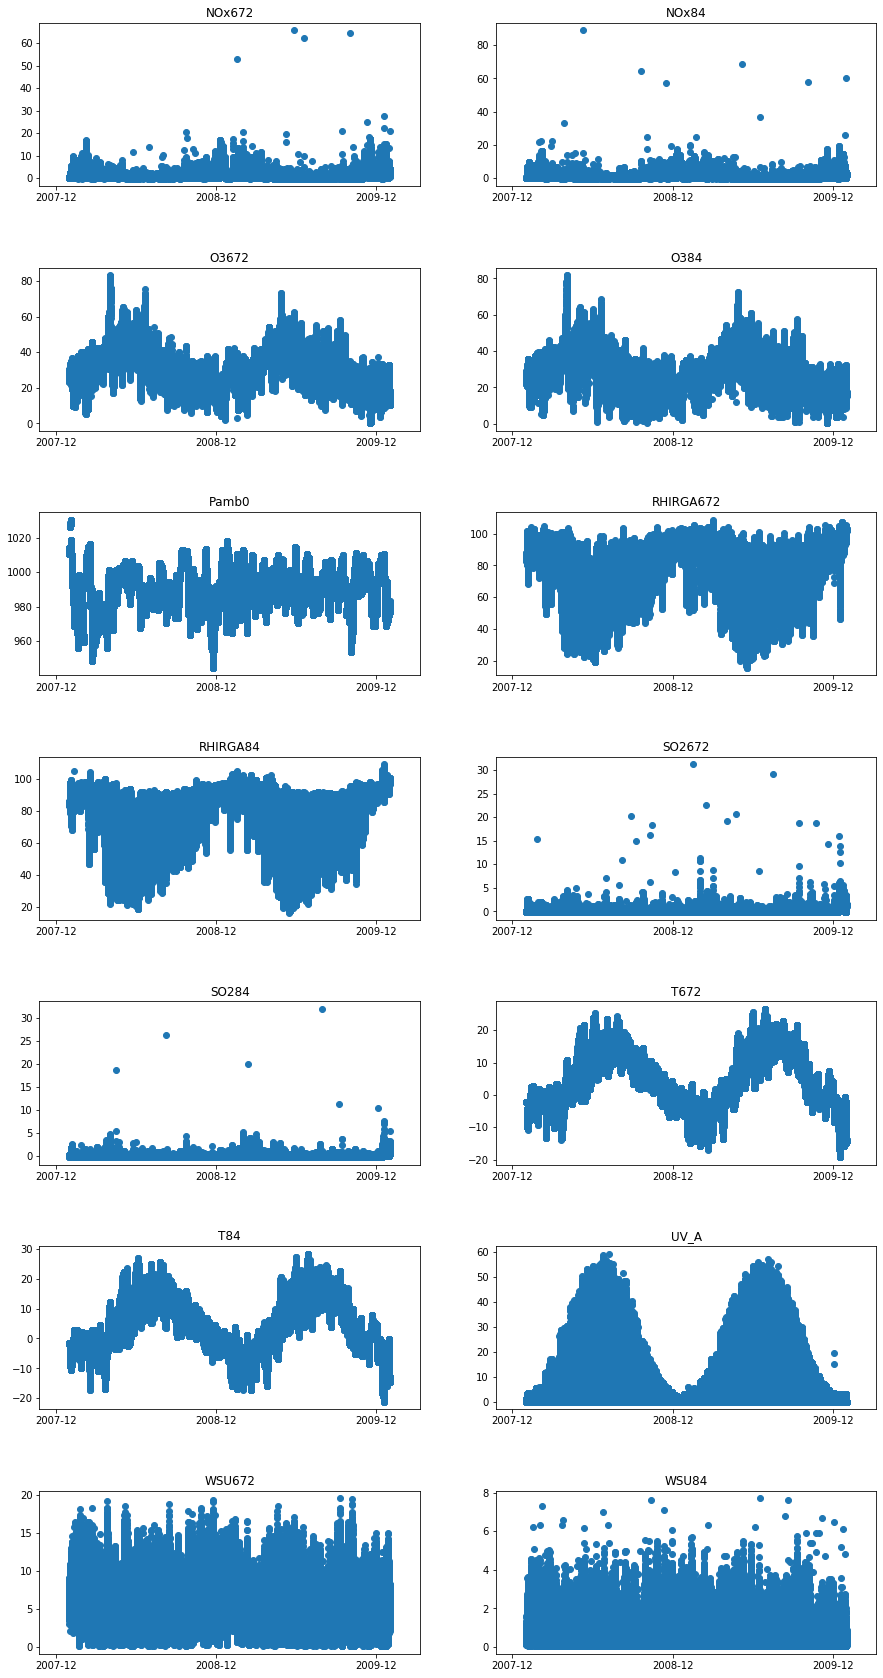

In [8]:
fig, axe = plt.subplots(7,2, figsize = (15, 30))
axe = axe.flatten()
for i in range(1, df.shape[1]):
    axe[i-1].scatter(df.Time, df.iloc[:,i])
    axe[i-1].set_title(df.columns[i])
    axe[i-1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

### Correlation plot
Choose color color bar first

In [9]:
cmap = sns.choose_diverging_palette(as_cmap = True)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

Change the color bar above then run the code below again to apply new color bar (Don't run the code above again)

(14, 0)

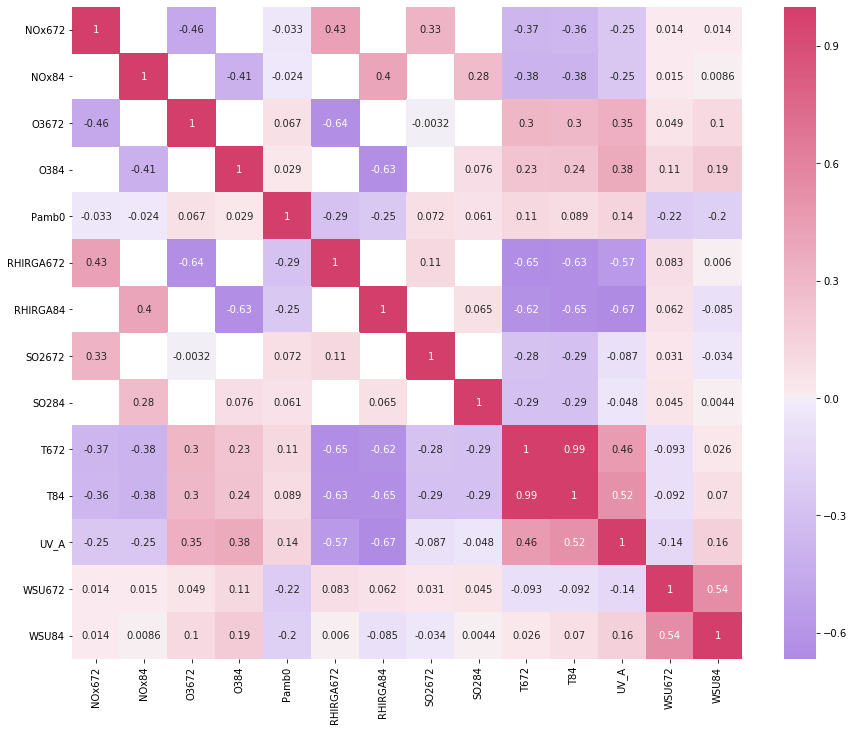

In [14]:
fig, ax = plt.subplots(figsize = (15,12))
sns.heatmap(df.corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(14,0)

Correlation matrix

In [11]:
df.corr()

,NOx672,NOx84,O3672,O384,Pamb0,RHIRGA672,RHIRGA84,SO2672,SO284,T672,T84,UV_A,WSU672,WSU84
NOx672,1.000000,NaN,-0.462859,NaN,-0.032647,0.426780,NaN,0.328748,NaN,-0.370380,-0.361902,-0.253445,0.013566,0.013756
NOx84,NaN,1.000000,NaN,-0.405497,-0.024343,NaN,0.396815,NaN,0.279872,-0.384111,-0.381718,-0.251644,0.014758,0.008633
O3672,-0.462859,NaN,1.000000,NaN,0.066916,-0.635837,NaN,-0.003173,NaN,0.304938,0.295656,0.346870,0.049201,0.102469
O384,NaN,-0.405497,NaN,1.000000,0.028516,NaN,-0.630418,NaN,0.076194,0.226794,0.243623,0.380534,0.110191,0.190262
Pamb0,-0.032647,-0.024343,0.066916,0.028516,1.000000,-0.285725,-0.247104,0.072226,0.061445,0.110711,0.089379,0.135535,-0.219699,-0.198785
RHIRGA672,0.426780,NaN,-0.635837,NaN,-0.285725,1.000000,NaN,0.109117,NaN,-0.648824,-0.630628,-0.567588,0.082790,0.005963
RHIRGA84,NaN,0.396815,NaN,-0.630418,-0.247104,NaN,1.000000,NaN,0.064894,-0.624301,-0.645013,-0.666862,0.061743,-0.084999
SO2672,0.328748,NaN,-0.003173,NaN,0.072226,0.109117,NaN,1.000000,NaN,-0.283675,-0.292906,-0.086674,0.031189,-0.033708
SO284,NaN,0.279872,NaN,0.076194,0.061445,NaN,0.064894,NaN,1.000000,-0.294856,-0.294138,-0.047676,0.045217,0.004433
T672,-0.370380,-0.384111,0.304938,0.226794,0.110711,-0.648824,-0.624301,-0.283675,-0.294856,1.000000,0.989895,0.463906,-0.093431,0.026042


Why so many NaN in the correlation matrix and plot?

In [12]:
(df.NOx672 + df.NOx84).isna().sum()

1052640

So all of those parameters are measured at different time with frequency more than base frequency of 30s. That's why there is not an observation that have those values at the same time.
<b> I think we should choose those parameters that have high correlation</b>